In [1]:
from mr_eval.utils.utils import *
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager

def list_jsonl_files(folder_path):
    """
    列举文件夹中的所有 .jsonl 文件
    Args:
        folder_path (str): 文件夹路径
    Returns:
        List[str]: 所有 .jsonl 文件的路径
    """
    return [f for f in os.listdir(folder_path) if f.endswith(".jsonl")]
## Model names
## Model names
prm_model_name_dict = dict(
    skyworkprm_1_5B="Skywork-1.5B",
    skyworkprm_7B="Skywork-PRM-7B",
    llemma7b_prm_prm800k="Llemma-PRM800k-7B",
    llemma7b_prm_metamath="Llemma-MetaMath-7B",
    llemma7b_oprm_prm800k="Llemma-oprm-7B",
    mathminos_mistral="MATHMinos-7B",
    mathshepherd="MathShepherd-7B",
    reasoneval7b="ReasonEval-7B",
    llama3_1_8b_prm_mistral="RLHFlow-PRM-Mistral-8B",
    llama3_1_8b_prm_deepseek="RLHFlow-PRM-Deepseek-8B",
    reasoneval34b="ReasonEval-34B",
)
close_model_name_dict = dict(
    gpt4o="GPT-4o",
    o1mini="o1-mini",
    o1preview="o1-preview",
    gemini_2_flash="Gemini-2.0-flash-exp",
    gemini_2_thinking="Gemini-thinking",
)
    
open_model_name_dict = dict(
    qwen_qwq="QwQ-Preview-32B",
)
all_model_name_dict = {**prm_model_name_dict, **close_model_name_dict, **open_model_name_dict}


classification_name_dict = dict(
    domain_inconsistency="DC.",
    redundency="NR.",
    multi_solutions="MS.",
    deception="DR.",
    confidence="CI.",
    step_contradiction="SC.",
    circular="NCL.",
    missing_condition="PS.",
    counterfactual="ES."
)
classification_parallel_dict = dict(
    simplicity=dict(
        redundency="NR.",
        circular="NCL.",
    ),
    soundness=dict(
        counterfactual="ES.",
        step_contradiction="SC.",
        domain_inconsistency="DC.",
        confidence="CI.",
    ),
    sensitivity=dict(
        missing_condition="PS.",
        deception="DR.",
        multi_solutions="MS.",
    )
)
classifications = ["redundency", "circular", "counterfactual", "step_contradiction", "domain_inconsistency",  "confidence", "missing_condition", "deception", "multi_solutions", ]
metrics = ["f1", "negative_f1", "total_step_acc", "correct_step_acc", "wrong_step_acc", "first_error_acc", "similarity",]

## File paths
res_dir = "/mnt/petrelfs/songmingyang/code/reasoning/MR_Hallucination/mr_eval/scripts/logs/prmtest_classified"
res_files = list_jsonl_files(res_dir)
res_names = [f.split(".")[0] for f in res_files]
res_paths = [os.path.join(res_dir, f) for f in res_files]
file_dict = dict(zip(res_names, res_paths))
res_dict = {k: process_jsonl(v)[-1] for k, v in file_dict.items()}
# detailed_log_dict = {k:v[""]}
display_models = ["reasoneval34b","mathshepherd","gpt4o","gemini_2_thinking"]

In [2]:
a = res_dict["gpt4o"]["detailed_logs"]
a[0].keys( )
a[0]["results"]

{'correct_step_acc': 1.0,
 'wrong_step_acc': -1,
 'total_step_acc': 1.0,
 'first_error_acc': None,
 'model_response_acc': 1.0,
 'f1_matrix': {'TP': 6, 'FP': 0, 'TN': 0, 'FN': 0},
 'correct_step_acc_list': [1, 1, 1, 1, 1, 1],
 'wrong_step_acc_list': [],
 'total_step_acc_list': [1, 1, 1, 1, 1, 1],
 'first_error_acc_list': [],
 'model_response_acc_list': [1.0]}

In [3]:
step_acc_dict = {k:{} for k in display_models}
cnt = 0
for model_name in display_models:
    detailed_log = res_dict[model_name]["detailed_logs"]
    for log in detailed_log:

        if  "validitiy" in log and not log["validitiy"]:
            cnt += 1
            continue
        # if not log["prediction"]  or ("validity" in log and not log["validitiy"]) or  ("validity" in log["prediction"] and not log["prediction"]["validity"]):
        #     cnt += 1
        #     continue
        error_steps = log["error_steps"]
        wrong_step_acc_list = log["results"]["wrong_step_acc_list"]    
        for idx,(error_step, wrong_step_acc) in enumerate(zip(error_steps, wrong_step_acc_list)):
            step_acc_dict[model_name][error_step] = step_acc_dict[model_name].get(error_step, []) + [wrong_step_acc]

for model_name, step_acc in step_acc_dict.items():
    for k,v in step_acc.items():
        step_acc_dict[model_name][k] = np.mean(v)

step_acc_list = {}
for model_name, step_acc in step_acc_dict.items():
    step_acc_list[model_name] = [step_acc.get(i, 0)*100 for i in range(1, 50)]


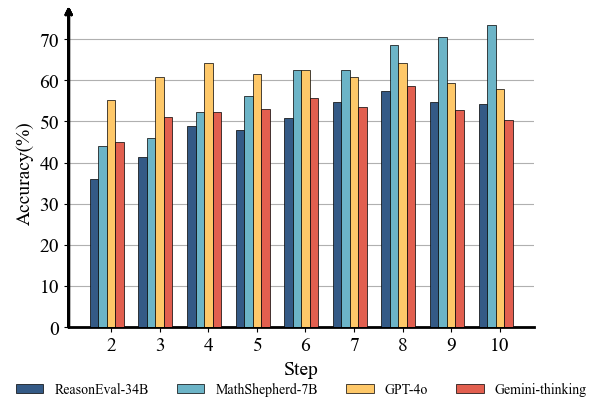

In [7]:
def generate_sequence(num):
    i = -num/2
    while i < num:
        yield i
        i = i+1
        
def draw():
    colors = [ "#345a86","#6cb4c7","#fec869","#e25f4f","#40724e", '#2691b1','#fab94f', '#e05e4e','#ff968d', '#b2ff89','#bc9eff','#bdbca5', 'grey', 'yellow','k','brown','grey','cyan',"pink"]
    draw_steps = list(range(2, 11))
    # for step in draw_steps:
    plt.figure(figsize=(6,4))
    generator = generate_sequence(len(display_models))
    for model_name in display_models:
        bar_width=0.7/len(display_models)
        index=np.arange(len(draw_steps))
        
        font_path = '/mnt/petrelfs/songmingyang/code/tools/tool_code/result_dealing/draw_fig/Comic Sans MS.ttf'  
        font_path = "/mnt/petrelfs/songmingyang/.config/fonts/Times New Roman.ttf"
        custom_font = font_manager.FontProperties(fname=font_path,size=14)
        custom_font_small = font_manager.FontProperties(fname=font_path)
        plt.grid(True,axis='y',zorder=1)
        plt.bar(index+next(generator)*bar_width,step_acc_list[model_name][draw_steps[0]:draw_steps[-1]+1],bar_width,label=f'{all_model_name_dict[model_name]}',color=colors.pop(0),zorder=3, edgecolor='black', linewidth=0.5)
        # plt.bar(index+next(generator)*bar_width,base_data,bar_width,label=f'LLaVA V1.5',color=colors.pop(0),zorder=3, edgecolor='black')
        
        plt.xticks(index,draw_steps,fontproperties=custom_font)
        plt.yticks(fontproperties=custom_font)
        plt.ylabel("Accuracy(%)",fontproperties=custom_font)
        plt.xlabel("Step",fontproperties=custom_font)
        plt.ylim(0, 75)
        # plt.legend(loc='lower left',zorder=100)
        plt.legend(loc='upper center', ncol=4,prop=custom_font_small, bbox_to_anchor=(0.5, -0.14),frameon=False)
        # 移除子图的边框
        ax = plt.gca()
        # 隐藏右边框和上边框
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        # ax.spines['bottom'].set_color('red')
        ax.spines['bottom'].set_linewidth(2)
        
        # endoffig=7.5
        # begin=3.4
        # plt.xlim(-1,endoffig)
        # end=endoffig
        # arrow_center=(begin+end)/2
        # height=70
        
        # plt.axvline(x=begin, color='r', linestyle='--')
        # plt.axvline(x=end, color='r', linestyle='--')
        
        # plt.annotate('', xy=(begin, height), xytext=(end, height), 
        #     arrowprops=dict(arrowstyle="<->", color='blue'),
        #     ha='center', va='bottom',fontproperties=custom_font)
        # plt.axvspan(begin,end , facecolor='y', alpha=0.5)
        # plt.annotate('Low Resource Languages', xy=(arrow_center, 95), xycoords='data',
        #     xytext=(0, -10), textcoords='offset points',
        #     ha='center', va='bottom',fontproperties=custom_font,
        #     bbox=dict(boxstyle='round,pad=0.5', facecolor="none", edgecolor="none", lw=0.5))
        # plt.savefig("./res/preliminary_dpo.pdf", format='pdf')
        
        # plt.annotate('', xy=(-1, height), xytext=(begin, height), 
        #     arrowprops=dict(arrowstyle="<->", color='blue'),
        #     ha='center', va='bottom',fontproperties=custom_font)
        # plt.axvspan(-1,begin-0.01 , facecolor='pink', alpha=0.5)
        # plt.annotate('High Resource Languages', xy=((begin-1)/2, 91), xycoords='data',
        #     xytext=(0, 0), textcoords='offset points',
        #     ha='center', va='bottom',fontproperties=custom_font,
        #     bbox=dict(boxstyle='round,pad=0.5', facecolor="none", edgecolor="none", lw=0.5))
        
        
        # plt.annotate('', xy=(end, 0.85), xytext=(endoffig, 0.85), 
        #  arrowprops=dict(arrowstyle="<->", color='blue'),
        #  ha='center', va='bottom',fontproperties=custom_font)
        # plt.axvspan(end,endoffig , facecolor='gray', alpha=0.5)
        # plt.annotate('LRL', xy=((end+endoffig)/2, 0.86), xycoords='data',
        #  xytext=(0, 0), textcoords='offset points',
        #  ha='center', va='bottom',fontproperties=custom_font,
        #  bbox=dict(boxstyle='round,pad=0.5', facecolor="none", edgecolor="none", lw=0.5))
        # plt.savefig("./res/preliminary_dpo.pdf", format='pdf')
        # for spine in ax.spines.values():
        #     spine.set_visible(False)
        # plt.title(f'{dataset_res["dataset_name"]}_{type_item["type_name"]}')

        # a_1000 = sum(plot_data["sft_1000"]["accuracy"]) / len(plot_data["sft_1000"]["accuracy"])
        # d_sh_hp = sum(plot_data["dpo_sh_hp"]["accuracy"]) / len(plot_data["dpo_sh_hp"]["accuracy"])
        # print(f"d_sh_hp: {d_sh_hp}, a_1000: {a_1000}")
        ax.annotate('', xy=(0, 1.05), xycoords='axes fraction', xytext=(0, -0.01),
            arrowprops=dict(arrowstyle="->", color='black',linewidth=2))
        plt.savefig("./res/step_acc.pdf", format='pdf',bbox_inches='tight')
draw()